\pagebreak
\tableofcontents
\pagebreak

In [170]:
'''Importing Packages'''
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from IPython.display import Markdown as md
import statsmodels.tsa.stattools as ts
import datetime
from loess import loess_1d
from statsmodels.graphics.tsaplots import plot_acf
from openpyxl import Workbook, load_workbook
%matplotlib inline

# Figure 1.1 The market yield on US Treasury Securities at 10-year constant maturity

## a) load and reconstruct the series data

In [171]:
'''Reading in Data'''

data_yield = pd.read_excel('data_changed_for_import.xlsx', sheet_name='B.1-10YTCM')
data_yield

,Month,"Rate, %",Month.1,"Rate, %.1",Month.2,"Rate, %.2",Month.3,"Rate, %.3"
0,1953-04-01,2.83,1966-10-01,5.01,1980-04-01,11.47,1993-10-01,5.33
1,1953-05-01,3.05,1966-11-01,5.16,1980-05-01,10.18,1993-11-01,5.72
2,1953-06-01,3.11,1966-12-01,4.84,1980-06-01,9.78,1993-12-01,5.77
3,1953-07-01,2.93,1967-01-01,4.58,1980-07-01,10.25,1994-01-01,5.75
4,1953-08-01,2.95,1967-02-01,4.63,1980-08-01,11.10,1994-02-01,5.97
...,...,...,...,...,...,...,...,...
157,1966-05-01,4.78,1979-11-01,10.65,1993-05-01,6.04,2006-11-01,4.60
158,1966-06-01,4.81,1979-12-01,10.39,1993-06-01,5.96,2006-12-01,4.56
159,1966-07-01,5.02,1980-01-01,10.80,1993-07-01,5.81,2007-01-01,4.76
160,1966-08-01,5.22,1980-02-01,12.41,1993-08-01,5.68,2007-02-01,4.72


## (b) convert the data into xts object

pandas automatically can read data types in python and create an index of date times. the work is done to create one dataframe stacked by the month columns.

In [172]:
month_columns = ['Month', 'Month.1', 'Month.2', 'Month.3']
rates_columns = ['Rate, %', 'Rate, %.1', 'Rate, %.2', 'Rate, %.3']
index_list = []
rates_list = []

for i in month_columns:
    for t in range(len(data_yield[i])):
        if data_yield[i].iloc[t] not in index_list:
            index_list.append(data_yield[i].iloc[t]) 


for i in rates_columns:
    for t in range(len(data_yield[i])):
            rates_list.append(data_yield[i].iloc[t]) 

data_yield_fixed = pd.DataFrame(index=index_list, columns=['Rates'])
data_yield_fixed['Rates'] = rates_list
data_yield_fixed = data_yield_fixed.dropna(axis=0)
data_yield_fixed.index.name = 'Month'

### Recreating the time series graph first

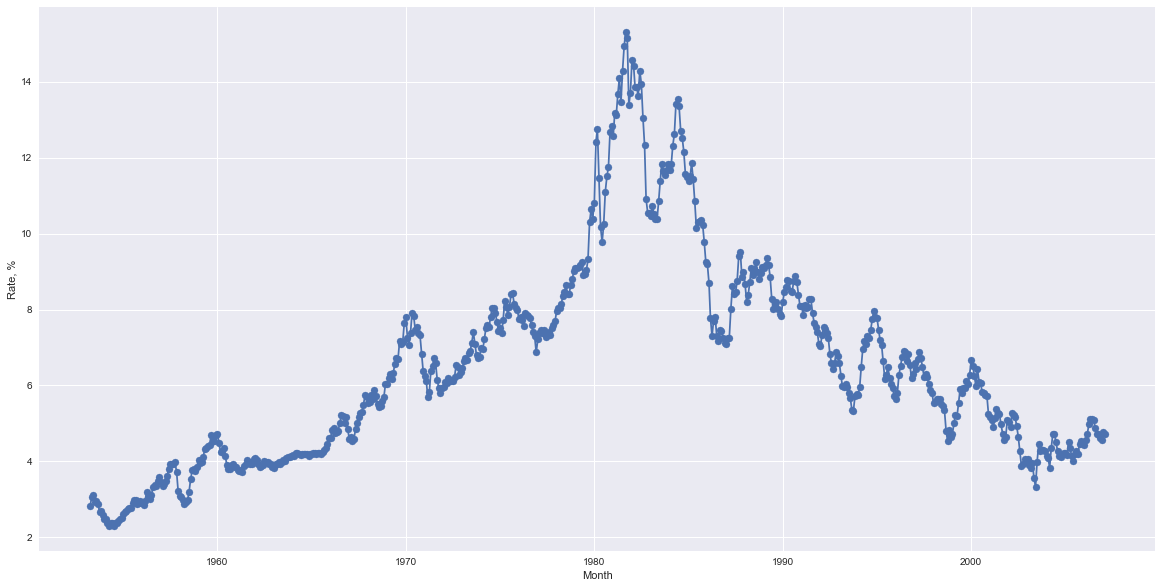

In [173]:
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes()
    plt.scatter(data_yield_fixed.index, data_yield_fixed['Rates'])
    plt.plot(data_yield_fixed)
    ax.set_xlabel('Month')
    ax.set_ylabel('Rate, %')
    plt.show()

## (c) generate the time series plot with loess smoothed curve overlapped.

In [174]:
data_yield_fixed.index = pd.to_datetime(data_yield_fixed.index)
data_yield_fixed['Month_num'] = [i for i in range(len(data_yield_fixed))]
x = np.array(data_yield_fixed['Month_num'])
y = np.array(data_yield_fixed['Rates'])

l = loess_1d.loess_1d(x, y, frac = 0.1, degree=2) 

data_yield_fixed['smoothed'] = l[1]
smoothed = pd.DataFrame(index=data_yield_fixed.index)
smoothed['Rates_sm'] = data_yield_fixed['smoothed']

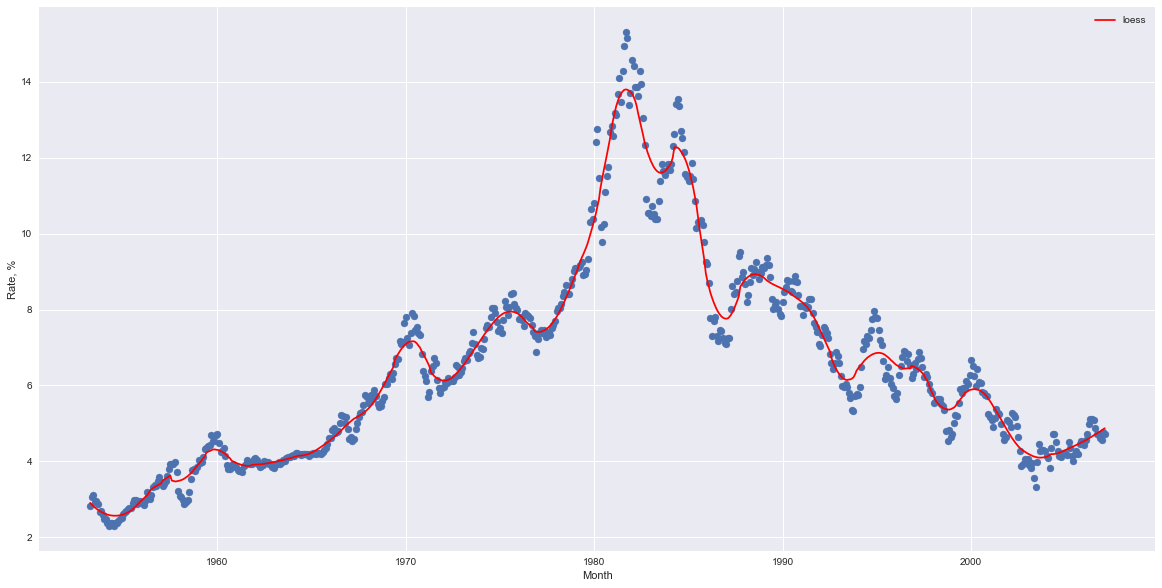

In [175]:
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes()
    plt.plot(smoothed, c = 'Red', label = 'loess')
    plt.scatter(data_yield_fixed.index, data_yield_fixed['Rates'])
    ax.set_xlabel('Month')
    ax.set_ylabel('Rate, %')
    plt.legend()
    plt.show()

## (d) generate the ACF plot (up to and including 25 lags)


<Figure size 1440x720 with 0 Axes>

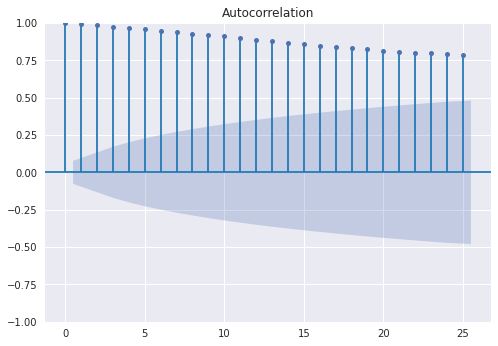

In [176]:
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(20,10))
    fig = plot_acf(data_yield_fixed['Rates'], lags=25)


## (e) generate the Variogram versus lag-k with asymptote $\frac{1}{1−r1}$ where $r_1$ is the lag-1 sample autocorrelation coefficient.

In [177]:
r1 = ts.acf(data_yield_fixed['Rates'], nlags=25)[1]
base_var  = np.var(data_yield_fixed['Rates'])

variogram = pd.DataFrame(index = [i for i in range(1,26)])
variogram['lagged'] = [np.var(np.array(data_yield_fixed['Rates'].iloc[i:]) - np.array(data_yield_fixed['Rates'].iloc[:-i]))/np.var(np.diff(data_yield_fixed['Rates'])) for i in range(1,26)]
variogram ['asymp'] = [1/(1-r1) for i in range(len(variogram))]

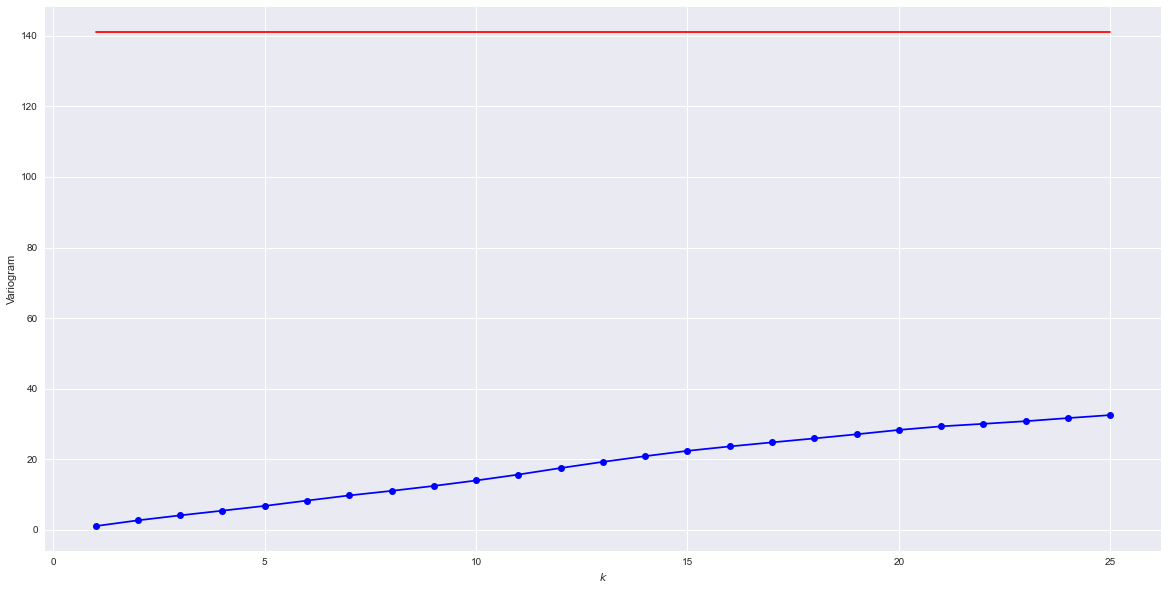

In [178]:
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes()
    plt.plot(variogram['lagged'], c = 'Blue', marker = 'o')
    plt.plot(variogram['asymp'], c = 'Red')
    ax.set_xlabel('$k$')
    ax.set_ylabel('Variogram')
    plt.show()

## (f) Comment on the stationarity of the series.

Based on the Variogram we can say this is most likely not Stationary.

# FIGURE 1.2 Pharmaceutical product sales.

## (a) load and reconstruct the series data / (b) convert the data into xts object

In [179]:
data_pharma = pd.read_excel('data_changed_for_import.xlsx', sheet_name='B.2-PHAR')
data_pharma

,Week,"Sales, in Thousands",Week.1,"Sales, in Thousands.1",Week.2,"Sales, in Thousands.2",Week.3,"Sales, in Thousands.3"
0,1,10618.1,31,10334.5,61,10538.2,91,10375.4
1,2,10537.9,32,10480.1,62,10286.2,92,10123.4
2,3,10209.3,33,10387.6,63,10171.3,93,10462.7
3,4,10553.0,34,10202.6,64,10393.1,94,10205.5
4,5,9934.9,35,10219.3,65,10162.3,95,10522.7
5,6,10534.5,36,10382.7,66,10164.5,96,10253.2
6,7,10196.5,37,10820.5,67,10327.0,97,10428.7
7,8,10511.8,38,10358.7,68,10365.1,98,10615.8
8,9,10089.6,39,10494.6,69,10755.9,99,10417.3
9,10,10371.2,40,10497.6,70,10463.6,100,10445.4


In [180]:
month_columns = ['Week', 'Week.1', 'Week.2', 'Week.3']
sales_column = ['Sales, in Thousands', 'Sales, in Thousands.1', 'Sales, in Thousands.2', 'Sales, in Thousands.3']
index_list = []
Sales_list = []

for i in month_columns:
    for t in range(len(data_pharma[i])):
        if data_pharma[i].iloc[t] not in index_list:
            index_list.append(data_pharma[i].iloc[t]) 


for i in sales_column:
    for t in range(len(data_pharma[i])):
            Sales_list.append(data_pharma[i].iloc[t]) 

data_pharma_fixed = pd.DataFrame(index=index_list, columns=['Sales'])
data_pharma_fixed['Sales'] = Sales_list
data_pharma_fixed = data_pharma_fixed.dropna(axis=0)
data_pharma_fixed.index.name = 'Week'

In [181]:
data_pharma_fixed

,Sales
Week,
1,10618.1
2,10537.9
3,10209.3
4,10553.0
5,9934.9
...,...
116,10650.0
117,10741.6
118,10246.0


## (c) generate the time series plot with loess smoothed curve overlapped.

In [182]:
x = np.array(data_pharma_fixed.index)
y = np.array(data_pharma_fixed['Sales'])

l = loess_1d.loess_1d(x, y, frac = 0.1, degree=2) 

data_pharma_fixed['smoothed'] = l[1]
smoothed = pd.DataFrame(index=data_pharma_fixed.index)
smoothed['Sales'] = data_pharma_fixed['smoothed']

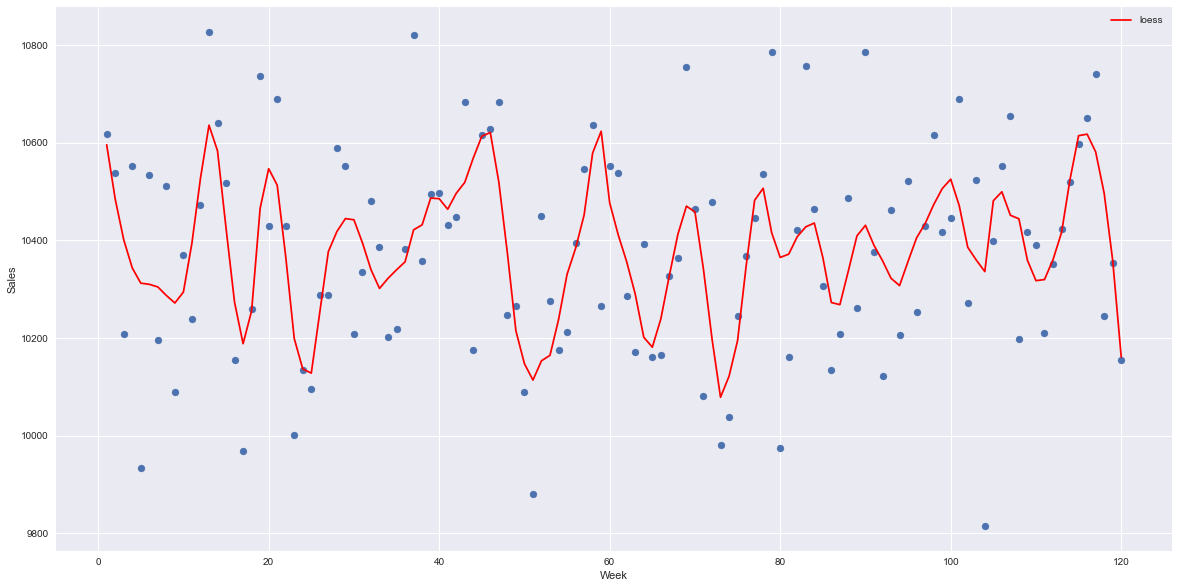

In [183]:
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes()
    plt.plot(smoothed, c = 'Red', label = 'loess')
    plt.scatter(data_pharma_fixed.index, data_pharma_fixed['Sales'])
    ax.set_xlabel('Week')
    ax.set_ylabel('Sales')
    plt.legend()
    plt.show()

## (d) generate the ACF plot (up to and including 25 lags)


<Figure size 1440x720 with 0 Axes>

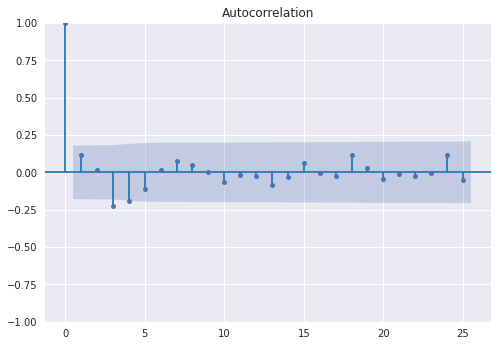

In [184]:
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(20,10))
    fig = plot_acf(data_pharma_fixed['Sales'], lags=25)

## (e) generate the Variogram versus lag-k with asymptote $\frac{1}{1−r1}$ where $r_1$ is the lag-1 sample autocorrelation coefficient.

In [185]:
r1 = ts.acf(data_pharma_fixed['Sales'], nlags=25)[1]
base_var  = np.var(data_pharma_fixed['Sales'])

variogram = pd.DataFrame(index = [i for i in range(1,26)])
variogram['lagged'] = [np.var(np.array(data_pharma_fixed['Sales'].iloc[i:]) - np.array(data_pharma_fixed['Sales'].iloc[:-i]))/np.var(np.diff(data_pharma_fixed['Sales'])) for i in range(1,26)]
variogram ['asymp'] = [1/(1-r1) for i in range(len(variogram))]

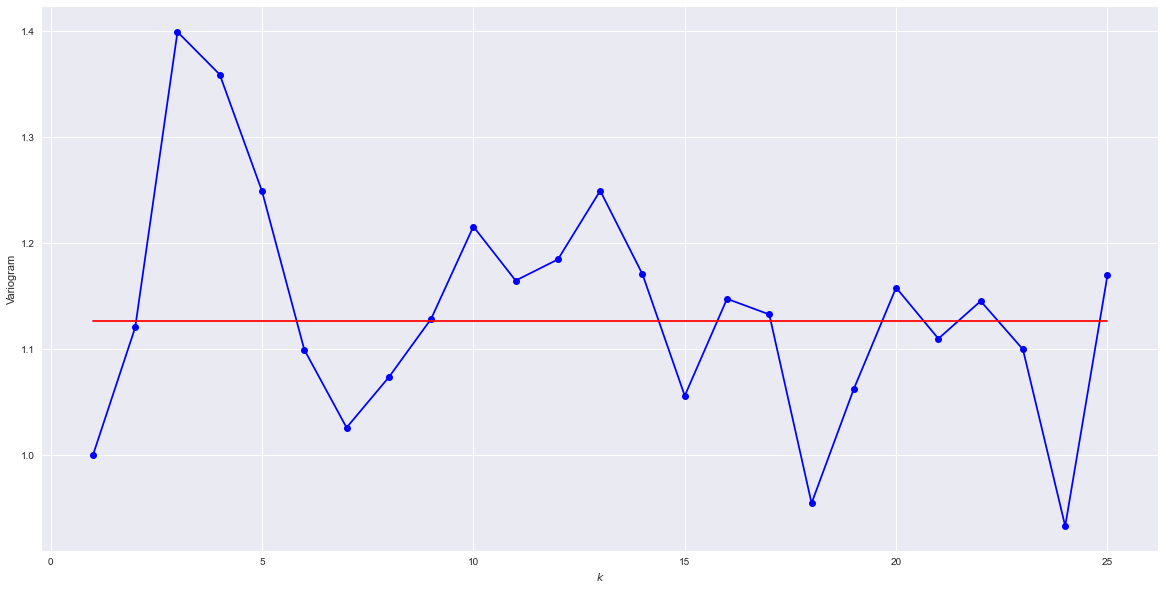

In [186]:
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes()
    plt.plot(variogram['lagged'], c = 'Blue', marker = 'o')
    plt.plot(variogram['asymp'], c = 'Red')
    ax.set_xlabel('$k$')
    ax.set_ylabel('Variogram')
    plt.show()

## (f) Comment on the stationarity of the series.

Based on the Variogram, we can say this series is most likely stationary

# FIGURE 1.3 Chemical process viscosity readings.

## (a) load and reconstruct the series data / (b) convert the data into xts object

In [187]:
data_visc = pd.read_excel('data_changed_for_import.xlsx', sheet_name='B.3-VISC')
data_visc

month_columns = ['Time Period', 'Time Period.1', 'Time Period.2', 'Time Period.3']
reading_column = ['Reading', 'Reading.1', 'Reading.2', 'Reading.3']
index_list = []
reading_list = []

for i in month_columns:
    for t in range(len(data_visc[i])):
        if data_visc[i].iloc[t] not in index_list:
            index_list.append(data_visc[i].iloc[t]) 


for i in reading_column:
    for t in range(len(data_visc[i])):
            reading_list.append(data_visc[i].iloc[t]) 

data_visc_fixed = pd.DataFrame(index=index_list, columns=['reading'])
data_visc_fixed['reading'] = reading_list
data_visc_fixed = data_visc_fixed.dropna(axis=0)
data_visc_fixed.index.name = 'Time Period'

In [188]:
data_visc_fixed

,reading
Time Period,
1,86.7418
2,85.3195
3,84.7355
4,85.1113
5,85.1487
...,...
96,85.7609
97,85.2302
98,86.7312


## (c) generate the time series plot with loess smoothed curve overlapped.

In [189]:
x = np.array(data_visc_fixed.index)
y = np.array(data_visc_fixed['reading'])

l = loess_1d.loess_1d(x, y, frac = 0.1, degree=2) 

data_visc_fixed['smoothed'] = l[1]
smoothed = pd.DataFrame(index=data_visc_fixed.index)
smoothed['reading'] = data_visc_fixed['smoothed']

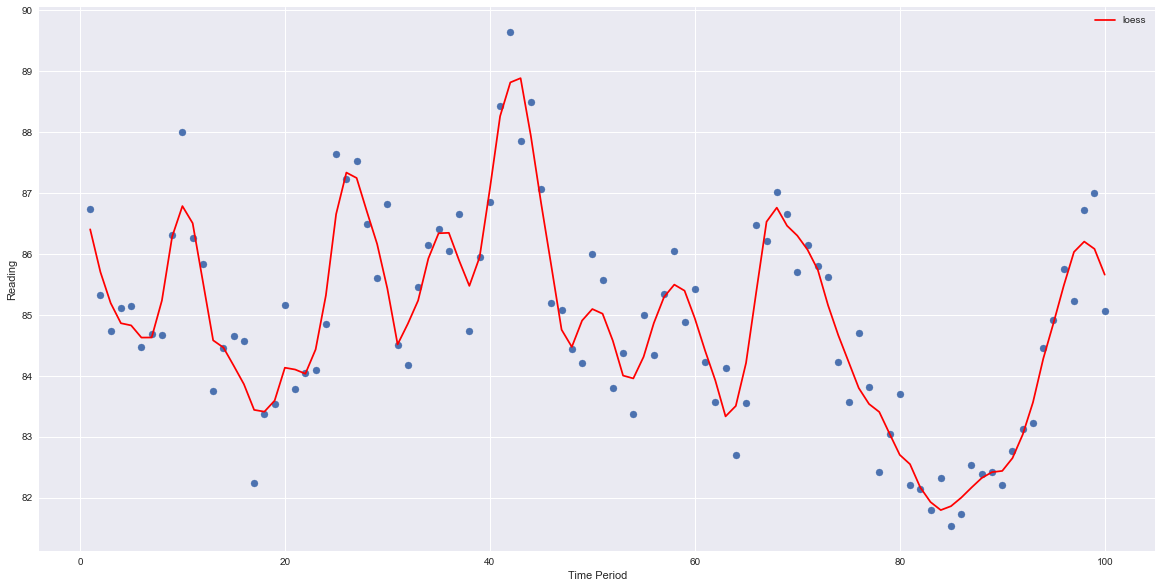

In [190]:
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes()
    plt.plot(smoothed, c = 'Red', label = 'loess')
    plt.scatter(data_visc_fixed.index, data_visc_fixed['reading'])
    ax.set_xlabel('Time Period')
    ax.set_ylabel('Reading')
    plt.legend()
    plt.show()

## (d) generate the ACF plot (up to and including 25 lags)


<Figure size 1440x720 with 0 Axes>

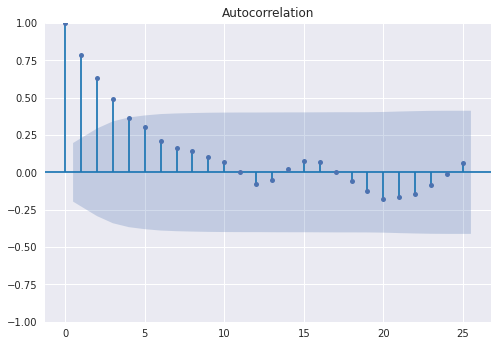

In [191]:
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(20,10))
    fig = plot_acf(data_visc_fixed['reading'], lags=25)

## (e) generate the Variogram versus lag-k with asymptote $\frac{1}{1−r1}$ where $r_1$ is the lag-1 sample autocorrelation coefficient.

In [192]:
r1 = ts.acf(data_visc_fixed['reading'], nlags=25)[1]
base_var  = np.var(data_visc_fixed['reading'])

variogram = pd.DataFrame(index = [i for i in range(1,26)])
variogram['lagged'] = [np.var(np.array(data_visc_fixed['reading'].iloc[i:]) - np.array(data_visc_fixed['reading'].iloc[:-i]))/np.var(np.diff(data_visc_fixed['reading'])) for i in range(1,26)]
variogram ['asymp'] = [1/(1-r1) for i in range(len(variogram))]

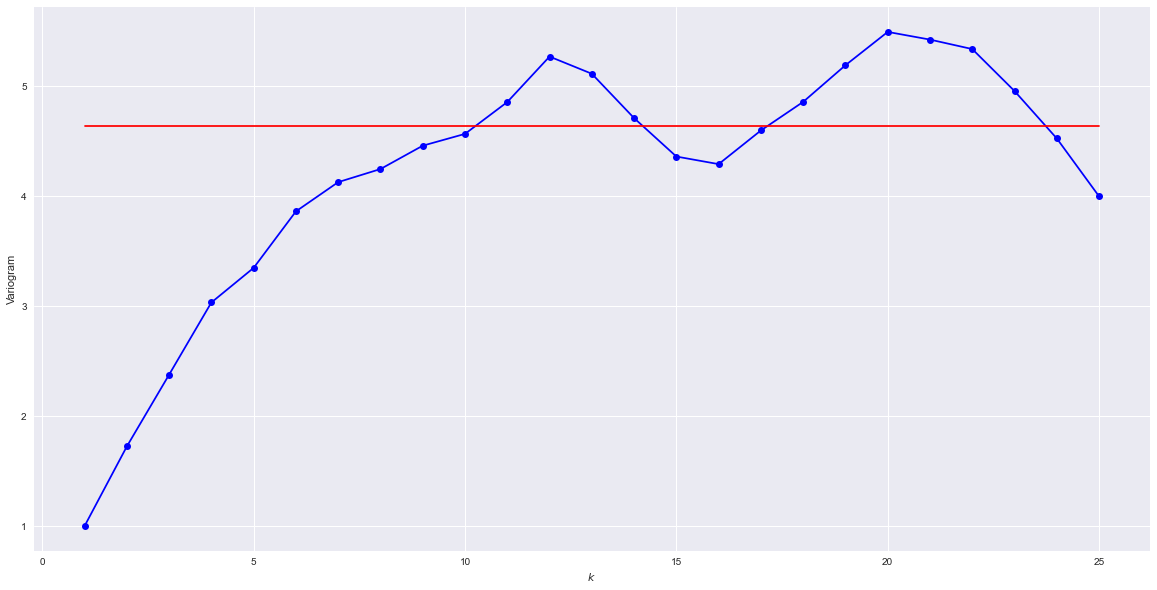

In [193]:
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes()
    plt.plot(variogram['lagged'], c = 'Blue', marker = 'o')
    plt.plot(variogram['asymp'], c = 'Red')
    ax.set_xlabel('$k$')
    ax.set_ylabel('Variogram')
    plt.show()

## (f) Comment on the stationarity of the series.

Based on the Variogram, we can say this is most likely stationary.

# FIGURE 1.4 TheUS annual production of blue and gorgonzola cheeses.

## (a) load and reconstruct the series data / (b) convert the data into xts object

In [194]:
data_blue = pd.read_excel('data_changed_for_import.xlsx', sheet_name='B.4-BLUE', index_col='Year')


## (c) generate the time series plot with loess smoothed curve overlapped.

In [195]:
x = np.array(data_blue.index)
y = np.array(data_blue['Production, thousand lbs'])

l = loess_1d.loess_1d(x, y, frac = 0.1, degree=2) 

data_blue['smoothed'] = l[1]
smoothed = pd.DataFrame(index=data_blue.index)
smoothed['Production, thousand lbs'] = data_blue['smoothed']

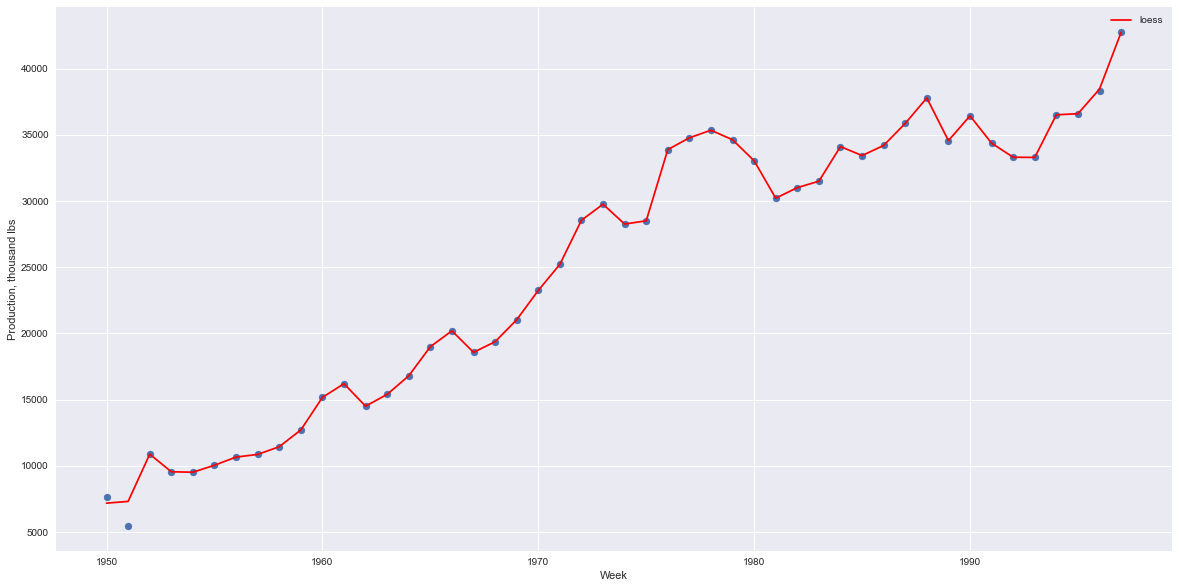

In [196]:
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes()
    plt.plot(smoothed, c = 'Red', label = 'loess')
    plt.scatter(data_blue.index, data_blue['Production, thousand lbs'])
    ax.set_xlabel('Week')
    ax.set_ylabel('Production, thousand lbs')
    plt.legend()
    plt.show()

## (d) generate the ACF plot (up to and including 25 lags)


<Figure size 1440x720 with 0 Axes>

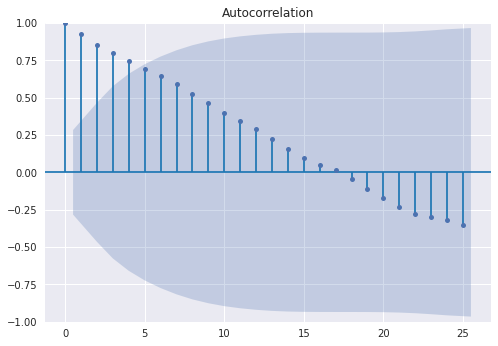

In [197]:
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(20,10))
    fig = plot_acf(data_blue['Production, thousand lbs'], lags=25)

## (e) generate the Variogram versus lag-k with asymptote $\frac{1}{1−r1}$ where $r_1$ is the lag-1 sample autocorrelation coefficient.

In [198]:
r1 = ts.acf(data_blue['Production, thousand lbs'], nlags=25)[1]
base_var  = np.var(data_blue['Production, thousand lbs'])

variogram = pd.DataFrame(index = [i for i in range(1,26)])
variogram['lagged'] = [np.var(np.array(data_blue['Production, thousand lbs'].iloc[i:]) - np.array(data_blue['Production, thousand lbs'].iloc[:-i]))/np.var(np.diff(data_blue['Production, thousand lbs'])) for i in range(1,26)]
variogram ['asymp'] = [1/(1-r1) for i in range(len(variogram))]

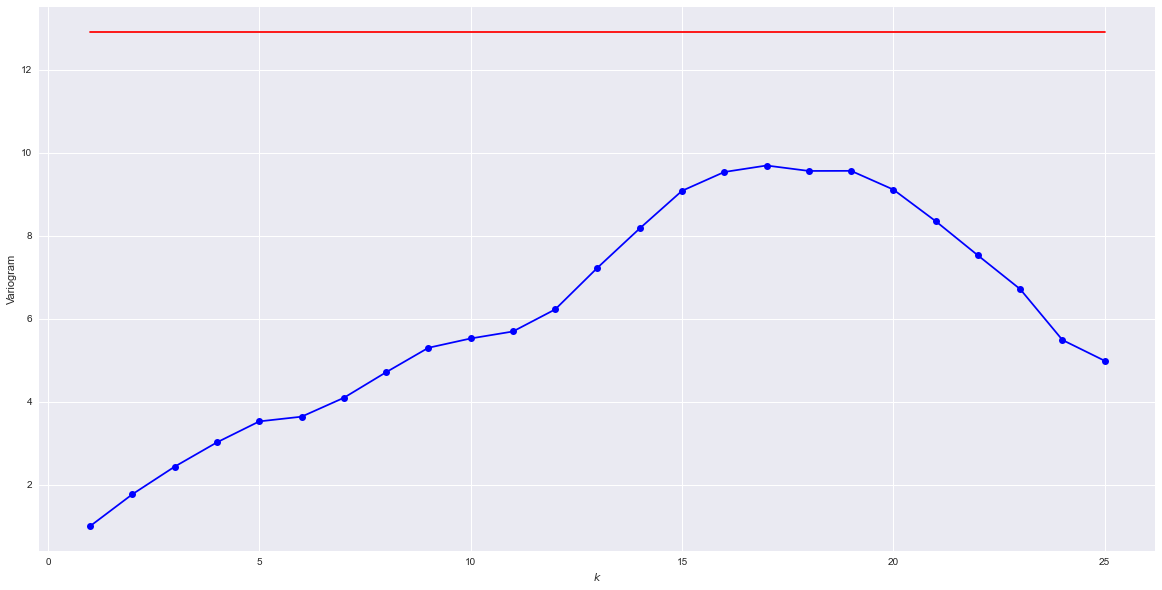

In [199]:
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes()
    plt.plot(variogram['lagged'], c = 'Blue', marker = 'o')
    plt.plot(variogram['asymp'], c = 'Red')
    ax.set_xlabel('$k$')
    ax.set_ylabel('Variogram')
    plt.show()

## (f) Comment on the stationarity of the series.

Based on the Variogram we can say this is most likely not Stationary.

# FIGURE 1.5 The US beverage manufacturer monthly product shipments

## (a) load and reconstruct the series data / (b) convert the data into xts object

In [200]:
data_bev = pd.read_excel('data_changed_for_import.xlsx', sheet_name='B.5-BEV')


In [201]:
month_columns = ['Month', 'Month.1', 'Month.2', 'Month.3']
dollars_column = ['Dollars, in Millions', 'Dollars, in Millions.1', 'Dollars, in Millions.2', 'Dollars, in Millions.3']
index_list = []
dollars_list = []

for i in month_columns:
    for t in range(len(data_bev[i])):
        if data_bev[i].iloc[t] not in index_list:
            index_list.append(data_bev[i].iloc[t]) 


for i in dollars_column:
    for t in range(len(data_bev[i])):
            dollars_list.append(data_bev[i].iloc[t]) 

data_bev_fixed = pd.DataFrame(index=index_list, columns=['Dollars, in Millions'])
data_bev_fixed['Dollars, in Millions'] = dollars_list
data_bev_fixed = data_bev_fixed.dropna(axis=0)
data_bev_fixed.index.name = 'Month'

## (c) generate the time series plot with loess smoothed curve overlapped.

In [202]:
data_bev_fixed.index = pd.to_datetime(data_bev_fixed.index)
data_bev_fixed['Month_num'] = [i for i in range(len(data_bev_fixed))]
x = np.array(data_bev_fixed['Month_num'])
y = np.array(data_bev_fixed['Dollars, in Millions'])

l = loess_1d.loess_1d(x, y, frac = 0.1, degree=2) 

data_bev_fixed['smoothed'] = l[1]
smoothed = pd.DataFrame(index=data_bev_fixed.index)
smoothed['Dollars, in Millions'] = data_bev_fixed['smoothed']

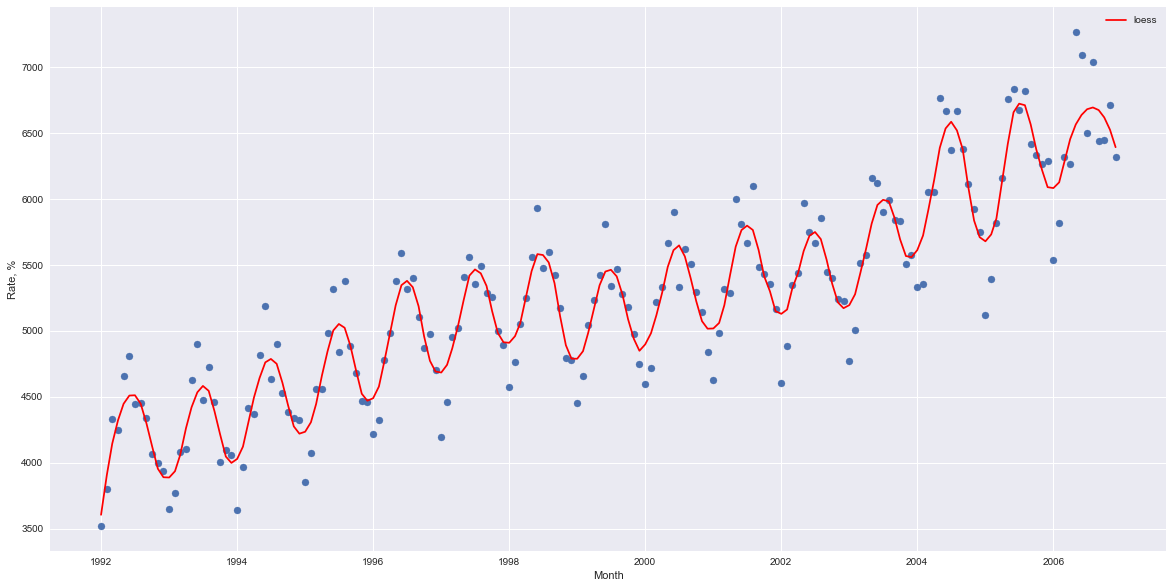

In [203]:
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes()
    plt.plot(smoothed, c = 'Red', label = 'loess')
    plt.scatter(data_bev_fixed.index, data_bev_fixed['Dollars, in Millions'])
    ax.set_xlabel('Month')
    ax.set_ylabel('Rate, %')
    plt.legend()
    plt.show()

## (d) generate the ACF plot (up to and including 25 lags)


<Figure size 1440x720 with 0 Axes>

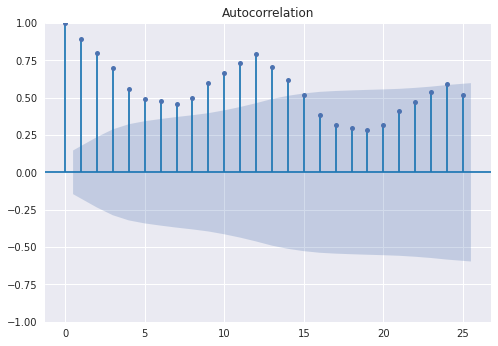

In [204]:
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(20,10))
    fig = plot_acf(data_bev_fixed['Dollars, in Millions'], lags=25)

## (e) generate the Variogram versus lag-k with asymptote $\frac{1}{1−r1}$ where $r_1$ is the lag-1 sample autocorrelation coefficient.

In [205]:
r1 = ts.acf(data_bev_fixed['Dollars, in Millions'], nlags=25)[1]
base_var  = np.var(data_bev_fixed['Dollars, in Millions'])

variogram = pd.DataFrame(index = [i for i in range(1,int(len(data_bev_fixed)/4))])
variogram['lagged'] = [np.var(np.array(data_bev_fixed['Dollars, in Millions'].iloc[i:]) - np.array(data_bev_fixed['Dollars, in Millions'].iloc[:-i]))/np.var(np.diff(data_bev_fixed['Dollars, in Millions'])) for i in range(1,int(len(data_bev_fixed)/4))]
variogram ['asymp'] = [1/(1-r1) for i in range(len(variogram))]

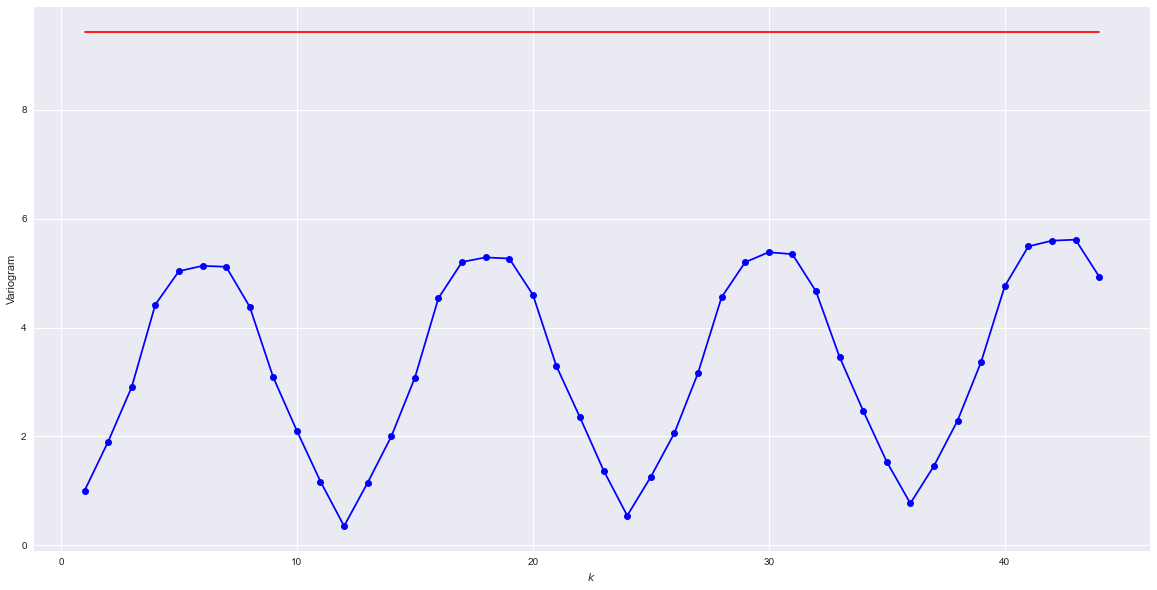

In [206]:
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes()
    plt.plot(variogram['lagged'], c = 'Blue', marker = 'o')
    plt.plot(variogram['asymp'], c = 'Red')
    ax.set_xlabel('$k$')
    ax.set_ylabel('Variogram')
    plt.show()

## (f) Comment on the stationarity of the series.

Based on the Variogram we can say this is most likely not Stationary.

# FIGURE 1.6 Global mean surface air temperature annual anomaly.

## (a) load and reconstruct the series data / (b) convert the data into xts object

In [207]:
data_temp_1 = pd.read_excel('data_changed_for_import.xlsx', sheet_name='B.6-GSAT-CO2', nrows= 43, usecols = 'A:C')
data_temp_2 = pd.read_excel('data_changed_for_import.xlsx', sheet_name='B.6-GSAT-CO2', nrows= 43, usecols = 'D:F')
data_temp_3 = pd.read_excel('data_changed_for_import.xlsx', sheet_name='B.6-GSAT-CO2', nrows= 42, usecols = 'G:I')

data_temp_2.columns = data_temp_1.columns.tolist()
data_temp_3.columns = data_temp_1.columns.tolist()

data_temp_1 = data_temp_1.set_index('Year')
data_temp_2 = data_temp_2.set_index('Year')
data_temp_3 = data_temp_3.set_index('Year')

data_temp_fixed = pd.concat([data_temp_1,data_temp_2,data_temp_3], axis=0)
data_temp_fixed = data_temp_fixed.dropna(axis=0)
data_temp_fixed = data_temp_fixed.drop(['CO2, ppmv'], axis = 1)

## (c) generate the time series plot with loess smoothed curve overlapped.

In [208]:

x = np.array(data_temp_fixed.index)
y = np.array(data_temp_fixed['Anomaly, C'])

l = loess_1d.loess_1d(x, y, frac = 0.1, degree=2) 

data_temp_fixed['smoothed'] = l[1]
smoothed = pd.DataFrame(index=data_temp_fixed.index)
smoothed['Anom'] = data_temp_fixed['smoothed']

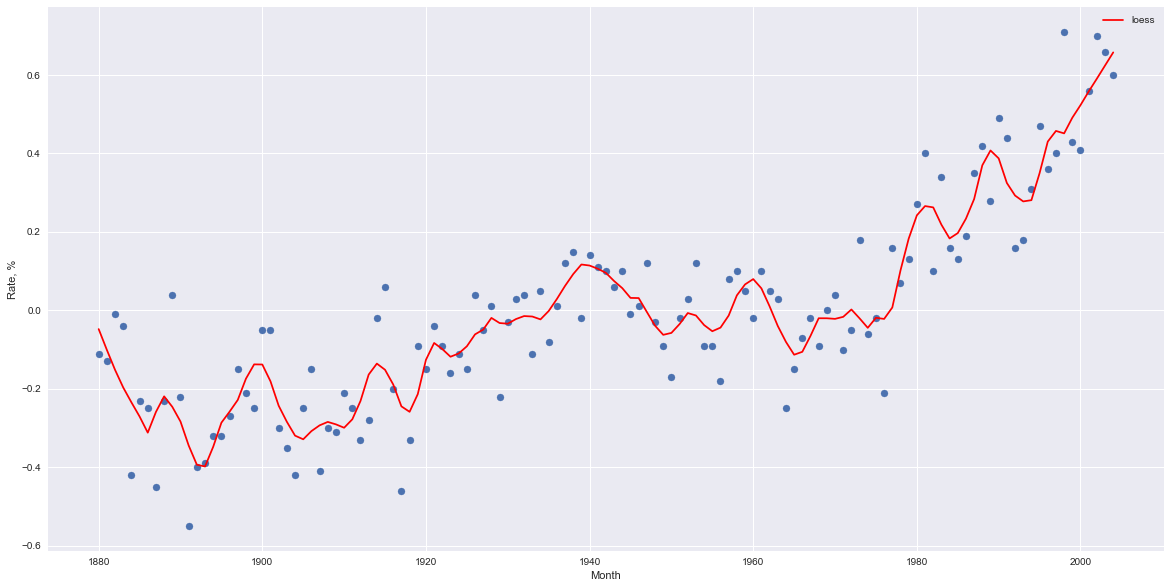

In [209]:
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes()
    plt.plot(smoothed, c = 'Red', label = 'loess')
    plt.scatter(data_temp_fixed.index, data_temp_fixed['Anomaly, C'])
    ax.set_xlabel('Month')
    ax.set_ylabel('Rate, %')
    plt.legend()
    plt.show()

## (d) generate the ACF plot (up to and including 25 lags)


<Figure size 1440x720 with 0 Axes>

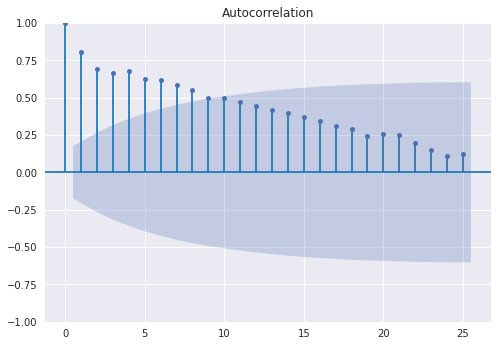

In [210]:
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(20,10))
    fig = plot_acf(data_temp_fixed['Anomaly, C'], lags=25)

## (e) generate the Variogram versus lag-k with asymptote $\frac{1}{1−r1}$ where $r_1$ is the lag-1 sample autocorrelation coefficient.

In [211]:
r1 = ts.acf(data_temp_fixed['Anomaly, C'], nlags=25)[1]
base_var  = np.var(data_temp_fixed['Anomaly, C'])

variogram = pd.DataFrame(index = [i for i in range(1,int(len(data_temp_fixed)/4))])
variogram['lagged'] = [np.var(np.array(data_temp_fixed['Anomaly, C'].iloc[i:]) - np.array(data_temp_fixed['Anomaly, C'].iloc[:-i]))/np.var(np.diff(data_temp_fixed['Anomaly, C'])) for i in range(1,int(len(data_temp_fixed)/4))]
variogram ['asymp'] = [1/(1-r1) for i in range(len(variogram))]

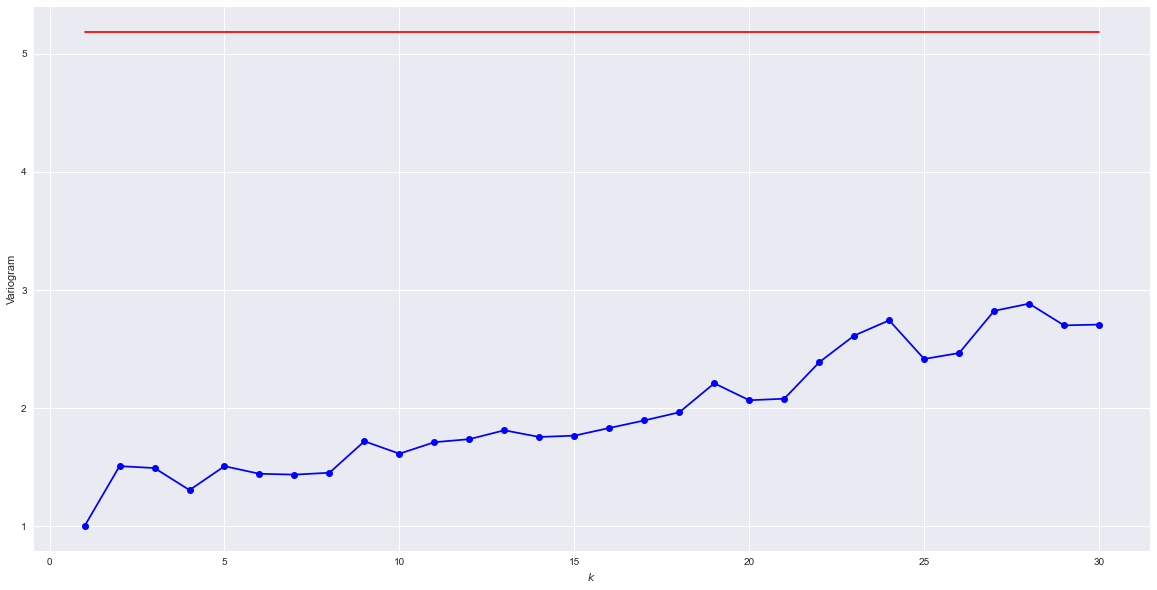

In [212]:
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes()
    plt.plot(variogram['lagged'], c = 'Blue', marker = 'o')
    plt.plot(variogram['asymp'], c = 'Red')
    ax.set_xlabel('$k$')
    ax.set_ylabel('Variogram')
    plt.show()

## (f) Comment on the stationarity of the series.

Based on the Variogram we can say this is most likely not Stationary.

# FIGURE 1.7 Whole foods market stock price

## (a) load and reconstruct the series data / (b) convert the data into xts object

In [213]:
data_WFMI_1 = pd.read_excel('data_changed_for_import.xlsx', sheet_name='B.7-WFMI', nrows= 51, usecols = 'A:B')
data_WFMI_2 = pd.read_excel('data_changed_for_import.xlsx', sheet_name='B.7-WFMI', nrows= 51, usecols = 'C:D')
data_WFMI_3 = pd.read_excel('data_changed_for_import.xlsx', sheet_name='B.7-WFMI', nrows= 51, usecols = 'E:F')
data_WFMI_4 = pd.read_excel('data_changed_for_import.xlsx', sheet_name='B.7-WFMI', nrows= 51, usecols = 'G:H')
data_WFMI_5 = pd.read_excel('data_changed_for_import.xlsx', sheet_name='B.7-WFMI', nrows= 49, usecols = 'I:J')

data_WFMI_2.columns = data_WFMI_1.columns.tolist()
data_WFMI_3.columns = data_WFMI_1.columns.tolist()
data_WFMI_4.columns = data_WFMI_1.columns.tolist()
data_WFMI_5.columns = data_WFMI_1.columns.tolist()

data_WFMI_1 = data_WFMI_1.set_index('Date')
data_WFMI_2 = data_WFMI_2.set_index('Date')
data_WFMI_3 = data_WFMI_3.set_index('Date')
data_WFMI_4 = data_WFMI_4.set_index('Date')
data_WFMI_5 = data_WFMI_5.set_index('Date')

data_WFMI_fixed = pd.concat([data_WFMI_1,data_WFMI_2,data_WFMI_3,data_WFMI_4,data_WFMI_5], axis=0)
data_WFMI_fixed = data_WFMI_fixed.dropna(axis=0)


## (c) generate the time series plot with loess smoothed curve overlapped.

In [214]:
data_WFMI_fixed.index = pd.to_datetime(data_WFMI_fixed.index)
data_WFMI_fixed['Month_num'] = [i for i in range(len(data_WFMI_fixed))]
x = np.array(data_WFMI_fixed['Month_num'])
y = np.array(data_WFMI_fixed['Dollars'])

l = loess_1d.loess_1d(x, y, frac = 0.1, degree=2) 

data_WFMI_fixed['smoothed'] = l[1]
smoothed = pd.DataFrame(index=data_WFMI_fixed.index)
smoothed['Dollars_sm'] = data_WFMI_fixed['smoothed']

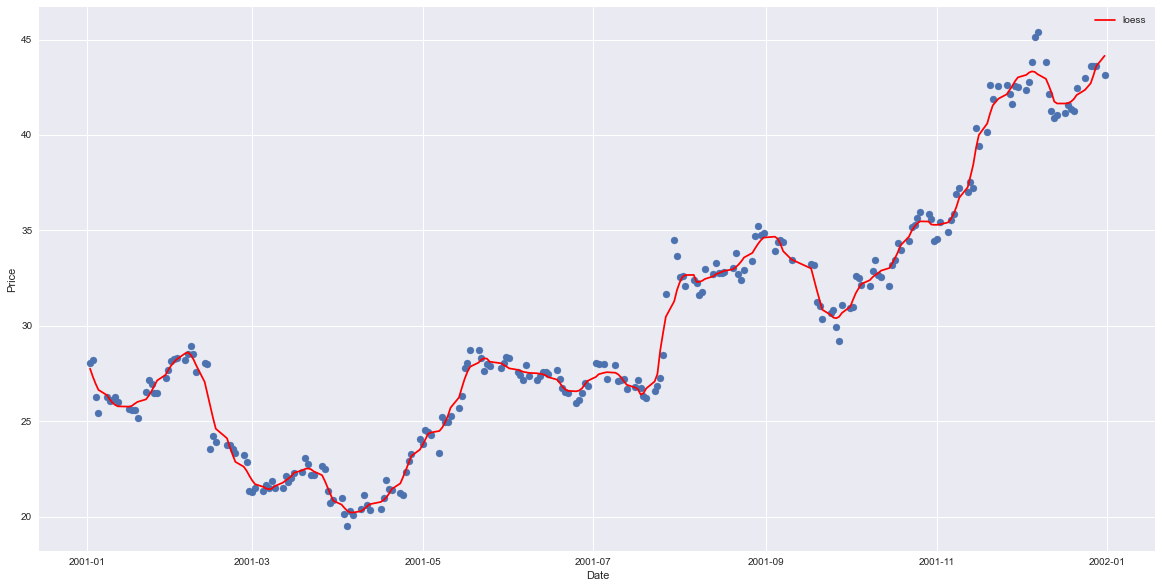

In [215]:
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes()
    plt.plot(smoothed, c = 'Red', label = 'loess')
    plt.scatter(data_WFMI_fixed.index, data_WFMI_fixed['Dollars'])
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    plt.legend()
    plt.show()

## (d) generate the ACF plot (up to and including 25 lags)


<Figure size 1440x720 with 0 Axes>

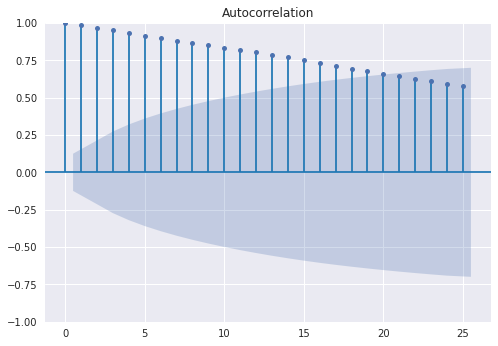

In [216]:
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(20,10))
    fig = plot_acf(data_WFMI_fixed['Dollars'], lags=25)

## (e) generate the Variogram versus lag-k with asymptote $\frac{1}{1−r1}$ where $r_1$ is the lag-1 sample autocorrelation coefficient.

In [217]:
r1 = ts.acf(data_WFMI_fixed['Dollars'], nlags=25)[1]
base_var  = np.var(data_WFMI_fixed['Dollars'])

variogram = pd.DataFrame(index = [i for i in range(1,int(len(data_WFMI_fixed)/4))])
variogram['lagged'] = [np.var(np.array(data_WFMI_fixed['Dollars'].iloc[i:]) - np.array(data_WFMI_fixed['Dollars'].iloc[:-i]))/np.var(np.diff(data_WFMI_fixed['Dollars'])) for i in range(1,int(len(data_WFMI_fixed)/4))]
variogram ['asymp'] = [1/(1-r1) for i in range(len(variogram))]

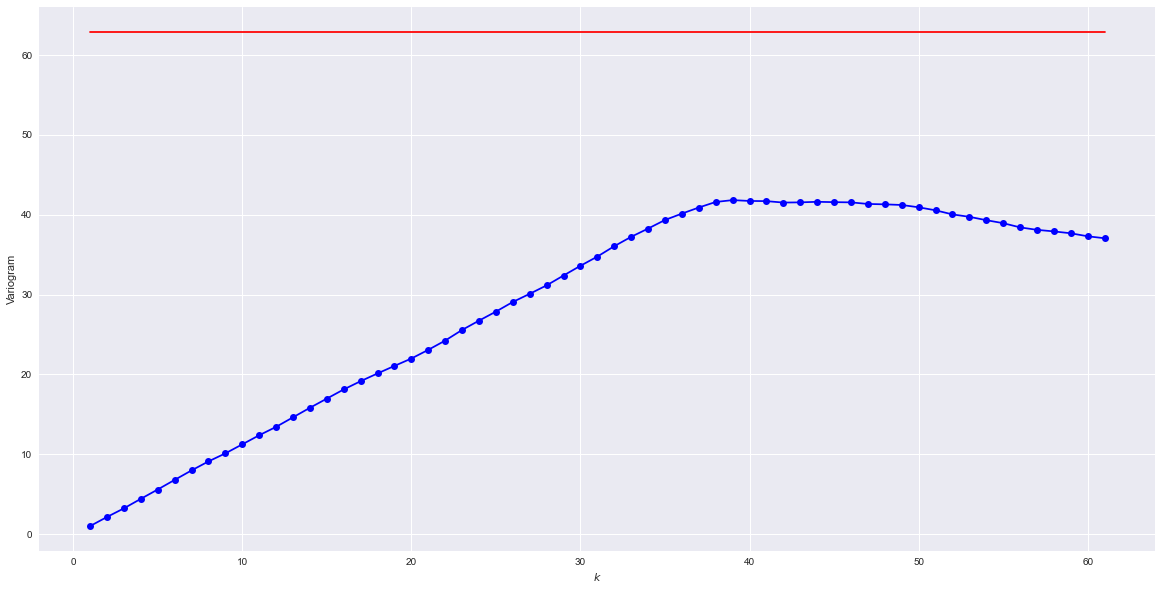

In [218]:
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes()
    plt.plot(variogram['lagged'], c = 'Blue', marker = 'o')
    plt.plot(variogram['asymp'], c = 'Red')
    ax.set_xlabel('$k$')
    ax.set_ylabel('Variogram')
    plt.show()

## (f) Comment on the stationarity of the series.

Based on the Variogram we can say this is most likely not Stationary.

# FIGURE 1.8 Monthly unemployment rate—full-time labor force.

## (a) load and reconstruct the series data / (b) convert the data into xts object

In [219]:
data_UNEMP_1 = pd.read_excel('data_changed_for_import.xlsx', sheet_name='B.8-UNEMP', nrows= 85, usecols = 'A:B')
data_UNEMP_2 = pd.read_excel('data_changed_for_import.xlsx', sheet_name='B.8-UNEMP', nrows= 85, usecols = 'C:D')
data_UNEMP_3 = pd.read_excel('data_changed_for_import.xlsx', sheet_name='B.8-UNEMP', nrows= 85, usecols = 'E:F')
data_UNEMP_4 = pd.read_excel('data_changed_for_import.xlsx', sheet_name='B.8-UNEMP', nrows= 85, usecols = 'G:H')
data_UNEMP_5 = pd.read_excel('data_changed_for_import.xlsx', sheet_name='B.8-UNEMP', nrows= 85, usecols = 'I:J')
data_UNEMP_6 = pd.read_excel('data_changed_for_import.xlsx', sheet_name='B.8-UNEMP', nrows= 85, usecols = 'K:L')

data_UNEMP_2.columns = data_UNEMP_1.columns.tolist()
data_UNEMP_3.columns = data_UNEMP_1.columns.tolist()
data_UNEMP_4.columns = data_UNEMP_1.columns.tolist()
data_UNEMP_5.columns = data_UNEMP_1.columns.tolist()
data_UNEMP_6.columns = data_UNEMP_1.columns.tolist()

data_UNEMP_1 = data_UNEMP_1.set_index('Month')
data_UNEMP_2 = data_UNEMP_2.set_index('Month')
data_UNEMP_3 = data_UNEMP_3.set_index('Month')
data_UNEMP_4 = data_UNEMP_4.set_index('Month')
data_UNEMP_5 = data_UNEMP_5.set_index('Month')
data_UNEMP_6 = data_UNEMP_6.set_index('Month')

data_UNEMP_fixed = pd.concat([data_UNEMP_1,data_UNEMP_2,data_UNEMP_3,data_UNEMP_4,data_UNEMP_5, data_UNEMP_6 ], axis=0)
data_UNEMP_fixed = data_UNEMP_fixed.dropna(axis=0)

## (c) generate the time series plot with loess smoothed curve overlapped.

In [220]:
data_UNEMP_fixed.index = pd.to_datetime(data_UNEMP_fixed.index)
data_UNEMP_fixed['Month_num'] = [i for i in range(len(data_UNEMP_fixed))]
x = np.array(data_UNEMP_fixed['Month_num'])
y = np.array(data_UNEMP_fixed['Rate %'])

l = loess_1d.loess_1d(x, y, frac = 0.1, degree=2) 

data_UNEMP_fixed['smoothed'] = l[1]
smoothed = pd.DataFrame(index=data_UNEMP_fixed.index)
smoothed['Rate %'] = data_UNEMP_fixed['smoothed']

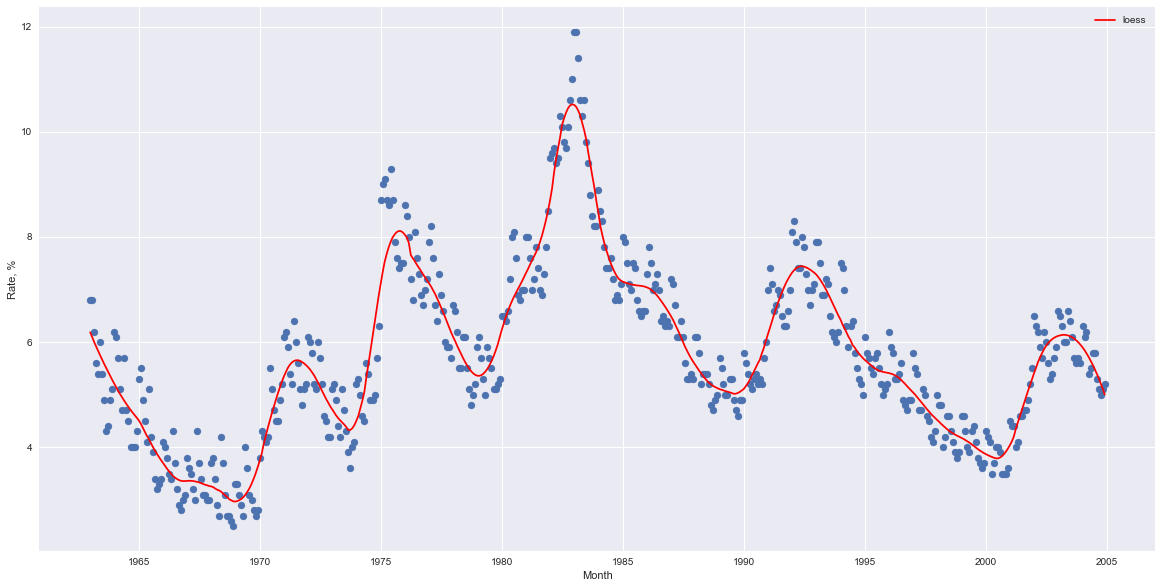

In [221]:
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes()
    plt.plot(smoothed, c = 'Red', label = 'loess')
    plt.scatter(data_UNEMP_fixed.index, data_UNEMP_fixed['Rate %'])
    ax.set_xlabel('Month')
    ax.set_ylabel('Rate, %')
    plt.legend()
    plt.show()

## (d) generate the ACF plot (up to and including 25 lags)


<Figure size 1440x720 with 0 Axes>

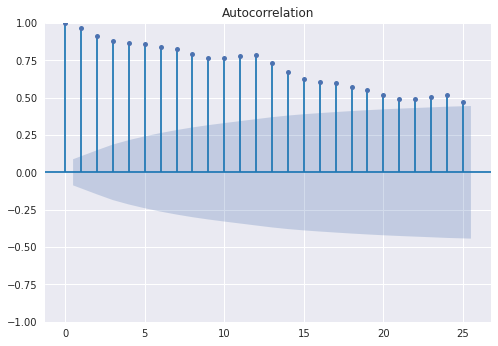

In [222]:
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(20,10))
    fig = plot_acf(data_UNEMP_fixed['Rate %'], lags=25)

## (e) generate the Variogram versus lag-k with asymptote $\frac{1}{1−r1}$ where $r_1$ is the lag-1 sample autocorrelation coefficient.

In [223]:
r1 = ts.acf(data_UNEMP_fixed['Rate %'], nlags=25)[1]
base_var  = np.var(data_UNEMP_fixed['Rate %'])

variogram = pd.DataFrame(index = [i for i in range(1,26)])
variogram['lagged'] = [np.var(np.array(data_UNEMP_fixed['Rate %'].iloc[i:]) - np.array(data_UNEMP_fixed['Rate %'].iloc[:-i]))/np.var(np.diff(data_UNEMP_fixed['Rate %'])) for i in range(1,26)]
variogram ['asymp'] = [1/(1-r1) for i in range(len(variogram))]

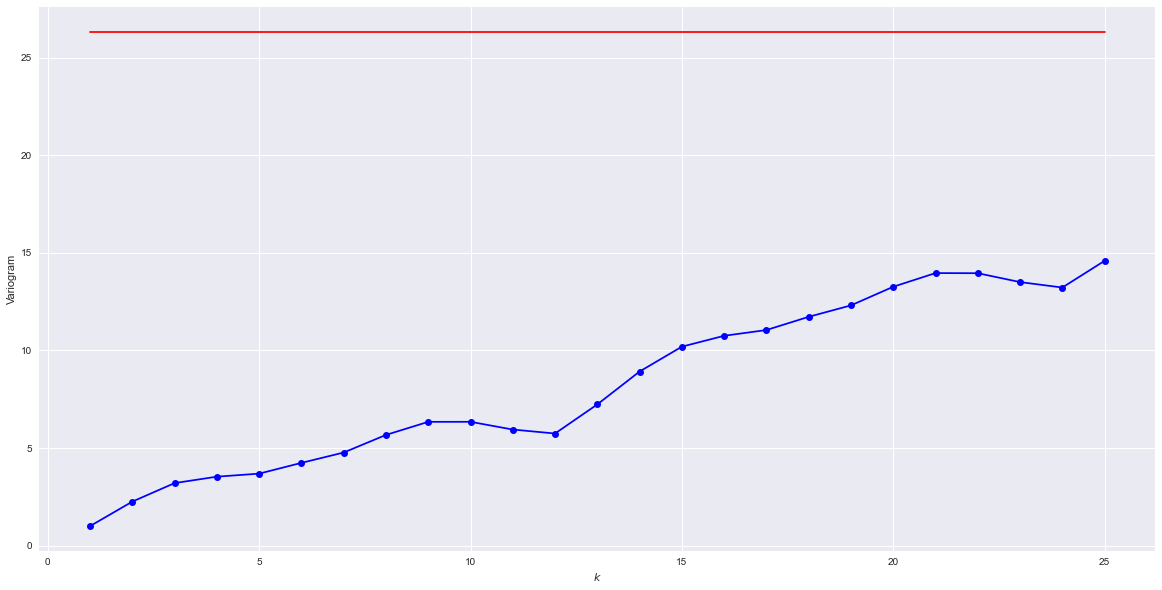

In [224]:
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes()
    plt.plot(variogram['lagged'], c = 'Blue', marker = 'o')
    plt.plot(variogram['asymp'], c = 'Red')
    ax.set_xlabel('$k$')
    ax.set_ylabel('Variogram')
    plt.show()

## (f) Comment on the stationarity of the series.

Based on the Variogram we can say this is most likely not Stationary.

# FIGURE 1.9 The international sunspot number

## (a) load and reconstruct the series data / (b) convert the data into xts object

In [225]:
data_SUNSPOT_1 = pd.read_excel('data_changed_for_import.xlsx', sheet_name='B.9-SUNSPOT', nrows= 62, usecols = 'A:B')
data_SUNSPOT_2 = pd.read_excel('data_changed_for_import.xlsx', sheet_name='B.9-SUNSPOT', nrows= 62, usecols = 'C:D')
data_SUNSPOT_3 = pd.read_excel('data_changed_for_import.xlsx', sheet_name='B.9-SUNSPOT', nrows= 62, usecols = 'E:F')
data_SUNSPOT_4 = pd.read_excel('data_changed_for_import.xlsx', sheet_name='B.9-SUNSPOT', nrows= 62, usecols = 'G:H')
data_SUNSPOT_5 = pd.read_excel('data_changed_for_import.xlsx', sheet_name='B.9-SUNSPOT', nrows= 62, usecols = 'I:J')

data_SUNSPOT_2.columns = data_SUNSPOT_1.columns.tolist()
data_SUNSPOT_3.columns = data_SUNSPOT_1.columns.tolist()
data_SUNSPOT_4.columns = data_SUNSPOT_1.columns.tolist()
data_SUNSPOT_5.columns = data_SUNSPOT_1.columns.tolist()

data_SUNSPOT_1 = data_SUNSPOT_1.set_index('Year')
data_SUNSPOT_2 = data_SUNSPOT_2.set_index('Year')
data_SUNSPOT_3 = data_SUNSPOT_3.set_index('Year')
data_SUNSPOT_4 = data_SUNSPOT_4.set_index('Year')
data_SUNSPOT_5 = data_SUNSPOT_5.set_index('Year')

data_SUNSPOT_fixed = pd.concat([data_SUNSPOT_1,data_SUNSPOT_2,data_SUNSPOT_3,data_SUNSPOT_4,data_SUNSPOT_5], axis=0)
data_SUNSPOT_fixed = data_SUNSPOT_fixed.dropna(axis=0)

## (c) generate the time series plot with loess smoothed curve overlapped.

In [226]:

x = np.array(data_SUNSPOT_fixed.index)
y = np.array(data_SUNSPOT_fixed['Sunspot Number'])

l = loess_1d.loess_1d(x, y, frac = 0.1, degree=2) 

data_SUNSPOT_fixed['smoothed'] = l[1]
smoothed = pd.DataFrame(index=data_SUNSPOT_fixed.index)
smoothed['Sunspot'] = data_SUNSPOT_fixed['smoothed']

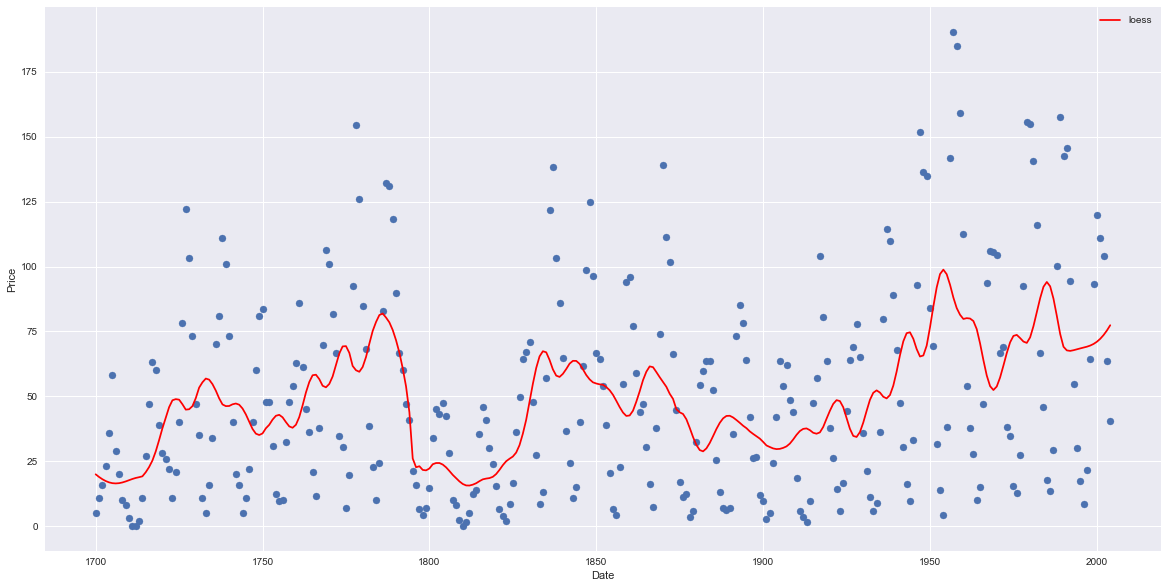

In [227]:
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes()
    plt.plot(smoothed, c = 'Red', label = 'loess')
    plt.scatter(data_SUNSPOT_fixed.index, data_SUNSPOT_fixed['Sunspot Number'])
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    plt.legend()
    plt.show()

## (d) generate the ACF plot (up to and including 25 lags)

<Figure size 1440x720 with 0 Axes>

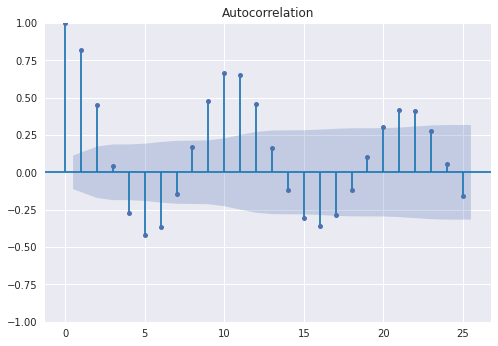

In [228]:
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(20,10))
    fig = plot_acf(data_SUNSPOT_fixed['Sunspot Number'], lags=25)

## (e) generate the Variogram versus lag-k with asymptote $\frac{1}{1−r1}$ where $r_1$ is the lag-1 sample autocorrelation coefficient.

In [229]:
r1 = ts.acf(data_SUNSPOT_fixed['Sunspot Number'], nlags=25)[1]
base_var  = np.var(data_SUNSPOT_fixed['Sunspot Number'])

variogram = pd.DataFrame(index = [i for i in range(1,int(len(data_SUNSPOT_fixed)/4))])
variogram['lagged'] = [np.var(np.array(data_SUNSPOT_fixed['Sunspot Number'].iloc[i:]) - np.array(data_SUNSPOT_fixed['Sunspot Number'].iloc[:-i]))/np.var(np.diff(data_SUNSPOT_fixed['Sunspot Number'])) for i in range(1,int(len(data_SUNSPOT_fixed)/4))]
variogram ['asymp'] = [1/(1-r1) for i in range(len(variogram))]

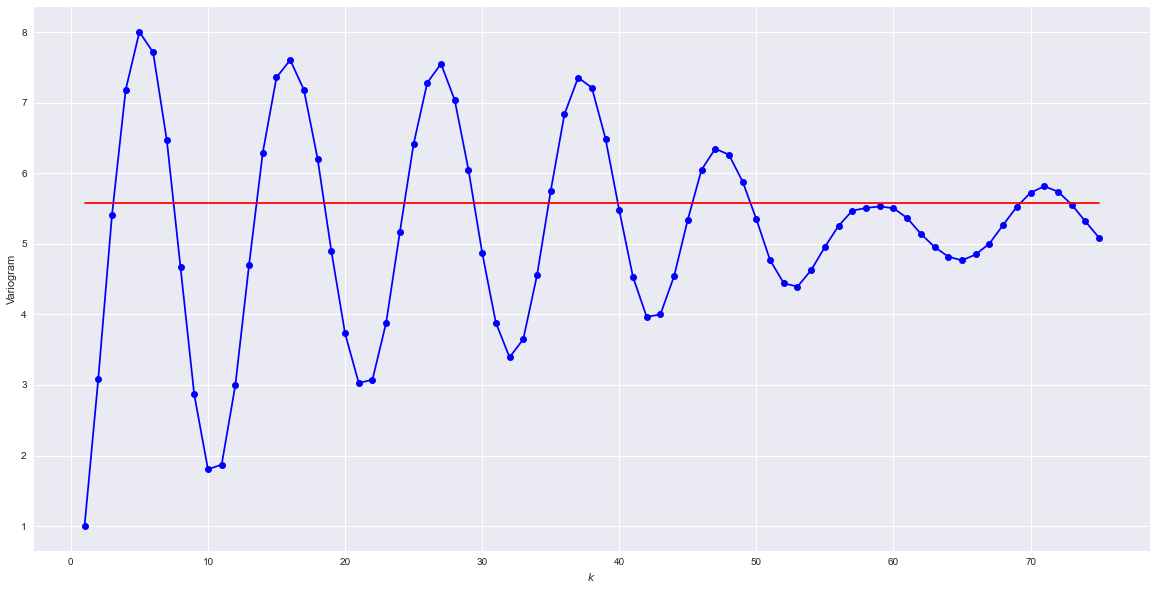

In [230]:
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes()
    plt.plot(variogram['lagged'], c = 'Blue', marker = 'o')
    plt.plot(variogram['asymp'], c = 'Red')
    ax.set_xlabel('$k$')
    ax.set_ylabel('Variogram')
    plt.show()

## (f) Comment on the stationarity of the series.

Based on the Variogram, we can say this series is most likely stationary